In [14]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

np.random.seed(42)


df = pd.read_csv('data/binance/BTCUSDT_1m_Futures.csv', index_col=0, parse_dates=True)
data = df[['Open', 'High', 'Low', 'Close', 'Volume']][-1000:]


data



,Open,High,Low,Close,Volume
Date,,,,,
2024-07-01 22:02:00,63033.9,63043.2,63028.9,63043.2,32.716
2024-07-01 22:03:00,63043.1,63047.2,63002.4,63015.4,57.031
2024-07-01 22:04:00,63015.3,63040.4,63015.3,63040.3,22.059
2024-07-01 22:05:00,63040.3,63043.4,63023.4,63034.4,38.873
2024-07-01 22:06:00,63034.9,63054.5,63034.7,63034.7,36.298
...,...,...,...,...,...
2024-07-02 14:37:00,62093.7,62093.7,62080.0,62093.0,39.111
2024-07-02 14:38:00,62092.9,62122.9,62086.6,62117.6,90.510
2024-07-02 14:39:00,62117.6,62142.0,62111.0,62142.0,63.159


<Axes: xlabel='Date'>

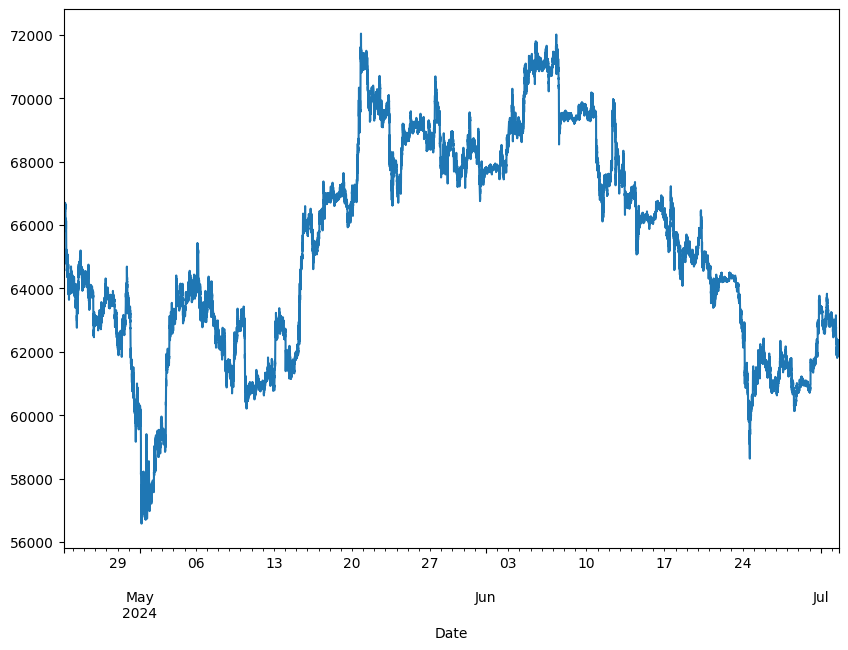

In [2]:
data['Close'].plot(figsize=(10, 7))

[63120.17781245 63112.75562489 63105.33343734 ... 62189.63860909
 62182.32326136 62175.00791364]


/tmp/ipykernel_239782/262057279.py:207: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(self.data.iloc[idx[0]].index, pos[idx], c=colors[p], s=4)


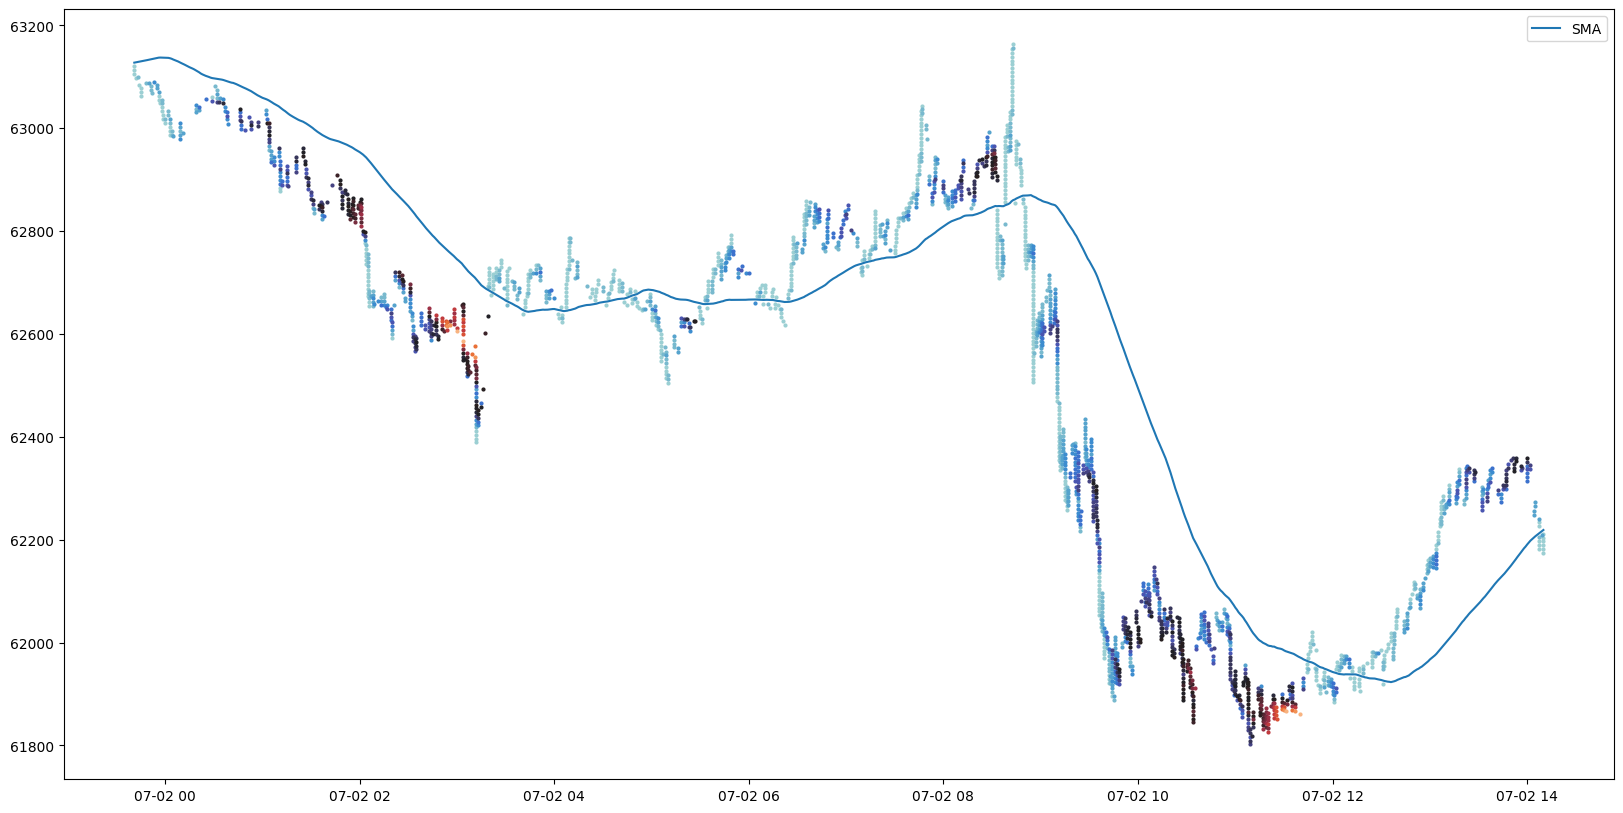

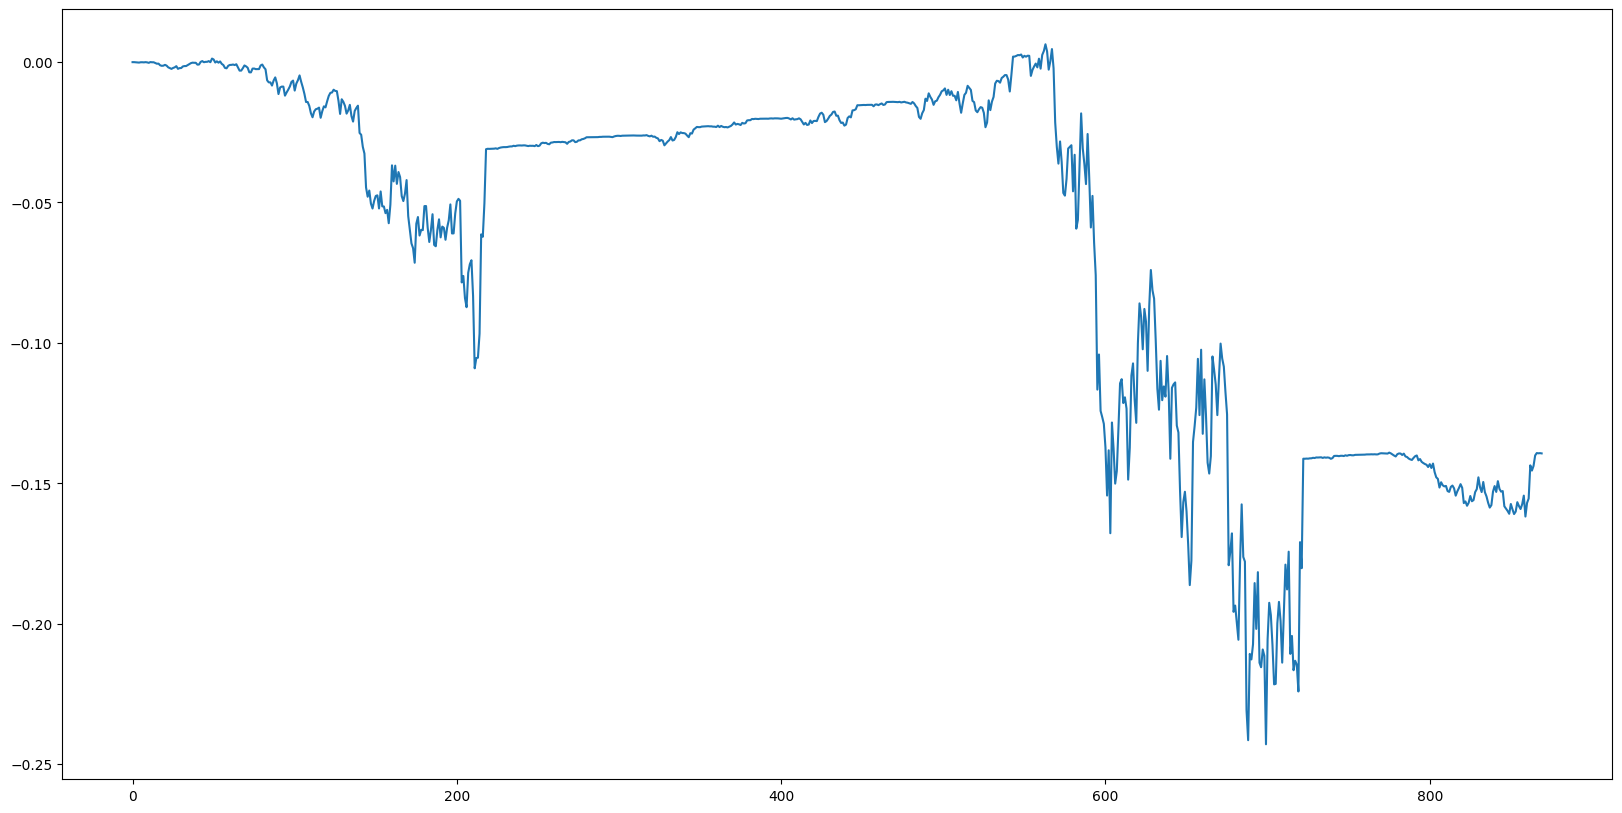

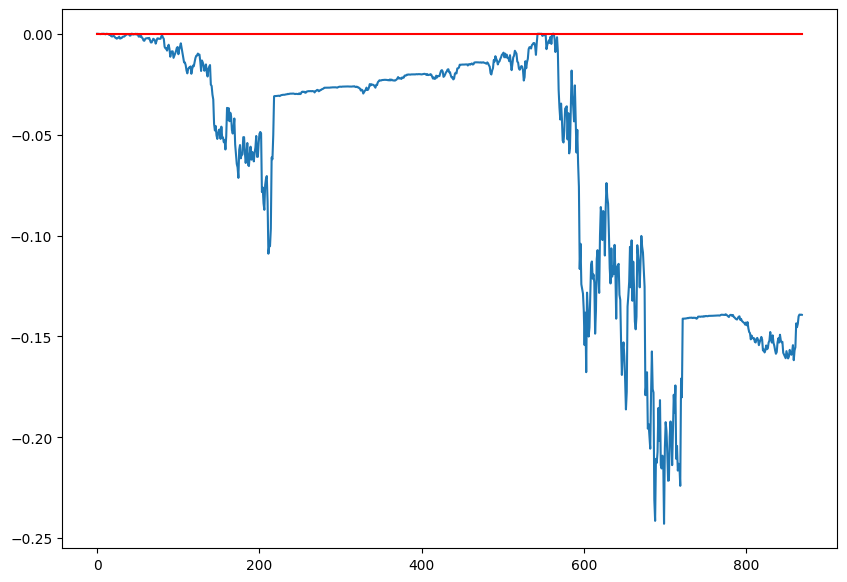

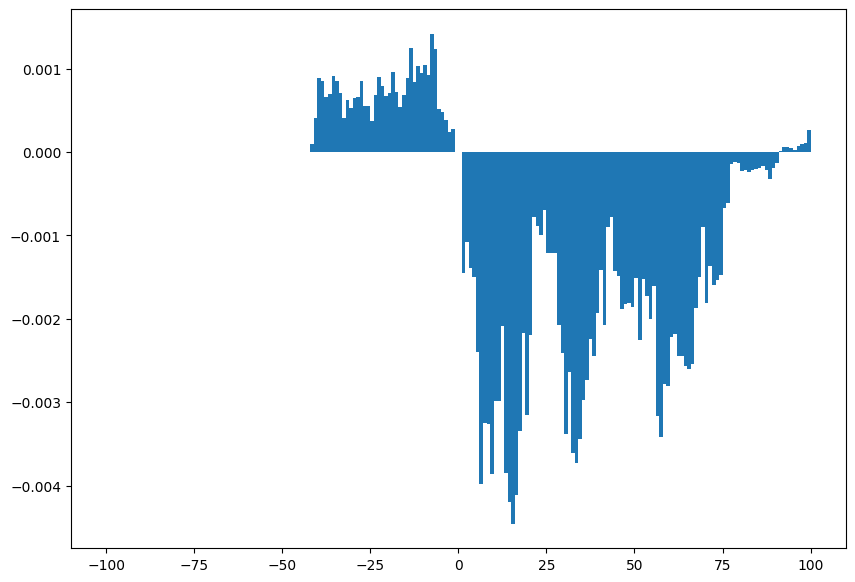

In [26]:
from numba import jit, njit, prange, vectorize, float64, int64, cuda, float32, guvectorize, void
from numba import float32, int32, int64, void, float64
from numba.typed import List
from numba.types import UniTuple
import seaborn as sns

import numba as nb


nb_float = float64
nb_int = int64



class Backtest:
    def __init__(self, data, ma_lenth=100, num_grid=100, fee=-0.00015, pyrimading=1):
        
        self.fee = fee
        self.pyramiding = np.ones(pyrimading, dtype=np.int64)/pyrimading
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.decimal = len(str(data.iloc[0]['Close']).split('.')[1]) if '.' in str(data.iloc[0]['Close']) else 0
        
        self.data.loc[:, 'SMA'] = self.data['Close'].rolling(window=ma_lenth).mean().round(self.decimal)
        
        self.max_diff = ((self.data['SMA']-self.data['Close'])/self.data['SMA']).abs().max()
        
        stop_idx = self.data[(self.data['SMA'] < self.data['High']) & (self.data['SMA'] > self.data['Low'])].index[-1]

        self.data = self.data[:stop_idx].dropna()
        
        id = np.concatenate([np.arange(-self.num_grid, 0, 1, dtype=int), np.arange(1, self.num_grid+1, dtype=int)])
        
        self.orders = {
            'id': id,
            'open_price': -id * self.max_diff/self.num_grid,
            'close_price': np.zeros(self.num_grid*2),
            'amount': np.sign(id),
            }

        self.orders = pd.DataFrame(self.orders)
        
        
        
    @staticmethod
    # @njit([UniTuple(nb_float[:, :], 2)(nb_float[:, :], nb_float[:, :], nb_float, nb_float[:])], parallel=True, fastmath=True)
    @njit(parallel=True, fastmath=True)
    def run_jit(data, orders,  fee, pyramiding):

        num_positions = np.zeros(len(orders), dtype=np.float64  )
        
        portfolio = np.zeros((len(data), len(orders)), dtype=np.float64)
        usdt_returns = np.zeros((len(data), len(orders)), dtype=np.float64)
        
        pos = np.zeros((len(data), len(orders), len(pyramiding)), dtype=np.float64)
        
        # pos = np.zeros((len(data), len(orders), len(pyramiding)), dtype=np.float64)
        
            
        for j in prange(len(orders)):
            
            id, open_on, close_on, amount = orders[j]
            
            opened_price = np.full(len(pyramiding), -1., dtype=np.float64)
            
            # opened_price = -1
            sum_positions = 0.
            
            normal_qty = 1 - fee
            


            for i in range(len(data)):
                open, high, low, close, volume, sma = data[i]
                open_price = (open_on +1 ) * sma
                close_price = (close_on +1 ) * sma
                
                
                if i == 0:
                    if amount > 0:
                        if open < open_price:
                            num_positions += 1
                            opened_price[0] = open_price
                            pos[i, j, 0] = open_price
                            
                    else:
                        if open > open_price:
                            num_positions += 1
                            opened_price[0] = open_price
                            pos[i, j, 0] = open_price
                    
                to_open = True

                for k in range(len(opened_price)):
                    
                    if to_open:
                        if opened_price[k] < 0:
                            
                            to_open = False

                            if amount > 0:
                                if low < open_price and open > open_price:
                                    opened_price[k] = open_price
                                    usdt_returns[i, j] -= normal_qty * pyramiding[k]
                                    num_positions[j] += 1
                                    pos[i, j, k] = open_price
                            else:
                                if high > open_price and open < open_price:
                                    opened_price[k] = open_price
                                    usdt_returns[i, j] += normal_qty * pyramiding[k]
                                    num_positions[j] += 1
                                    pos[i, j, k] = open_price
                                    
                        else:
                            if amount > 0:
                                if high > close_price and open < close_price:
                                    usdt_returns[i, j] += normal_qty * pyramiding[k]/opened_price[k]*close_price
                                    opened_price[k] = -1.
                            else:    
                                if low < close_price and open > close_price:
                                    usdt_returns[i, j] -= normal_qty * pyramiding[k]/opened_price[k]*close_price
                                    opened_price[k] = -1.
                        
                sum_positions += usdt_returns[i,j]
                port = sum_positions
                
                for k in range(len(opened_price)):
                    if opened_price[k] > 0:
                        port += 1/opened_price[k] * close * amount * pyramiding[k]
                    
                portfolio[i,j] = port

            
            for k in range(len(opened_price)):
                if opened_price[k] > 0:
                    usdt_returns[i,j] += 1/opened_price[k] * close * amount * pyramiding[k]
                        
        return usdt_returns, portfolio, pos

    def run(self):
        
        # positions = self.run_jit(self.data.to_numpy(), self.orders.to_numpy())

        # self.positions = positions
        self.usdt_returns, self.portfolio, self.pos = self.run_jit(self.data.to_numpy(), self.orders.to_numpy(), self.fee, self.pyramiding)
        self.drawdown = self.cummax_diff(self.portfolio.sum(axis=1))
        print(self.pos[self.pos != 0])
        
    
    def calc_amount(self):
        self.usdt_returns = self.usdt_returns * self.orders['amount'].to_numpy()
        self.portfolio = self.portfolio * self.orders['amount'].to_numpy()
        self.drawdown = self.cummax_diff(self.portfolio.sum(axis=1))
        
    # @staticmethod
    # @guvectorize([(float64[:], float64[:])], '(n)->(n)', target='cpu', nopython=True)
    # def cummax_diff(A, B):
    #     max_val = A[0]
        
    #     for i in range(len(A)):
    #         if A[i] < max_val:
    #             B[i] = A[i] - max_val
    #         else:
    #             max_val = A[i]
    #             B[i] = 0
    
    @staticmethod
    @njit(parallel=True)
    def cummax_diff(A):
        
        B = np.zeros_like(A)
        
        max_val = A[0]
        
        for i in prange(len(A)):
            if A[i] < max_val:
                B[i] = A[i] - max_val
            else:
                max_val = A[i]
                B[i] = 0
        return B

    def test_jit(self):
        
        self.port = np.zeros_like(self.usdt_returns)

        self.drawdown = self.portfolio.sum(axis=1) - self.port
        
    def plot(self, n =99):
        
        plt.figure(figsize=(20, 10))
        # plt.plot(self.data['Close'], label='Close')
        plt.plot(self.data['SMA'], label='SMA')
        # plt.plot(self.data['High'], label='High')   
        # plt.plot(self.data['Low'], label='Low')
        
        
        colors = sns.color_palette('icefire', len(self.pyramiding))
        
        for p in range(len(self.pyramiding)):
            pos = self.pos[:, :, p]
            
            idx = np.where(pos != 0)
            plt.scatter(self.data.iloc[idx[0]].index, pos[idx], c=colors[p], s=4)
        
        # idx = np.where(self.pos != 0)
        # plt.scatter(self.data.iloc[idx[0]].index, self.pos[idx], c='m', s=2)
        plt.legend()
        
        # plt.show()
        
        plt.figure(figsize=(20, 10))
        plt.plot(self.portfolio.sum(axis=1), label='Portfolio')
        plt.show()
        plt.figure(figsize=(10, 7))
        plt.plot(self.drawdown, label='Drawdown')
        plt.plot(np.zeros(self.portfolio.shape[0]), c='r')
        plt.show()
        plt.figure(figsize=(10, 7))
        plt.hist(x=self.orders['id'], weights=self.usdt_returns.sum(axis=0), bins=self.num_grid*2)

bt = Backtest(data, pyrimading=20)

bt.run()
bt.plot(90) 

In [10]:
%timeit -n 10 -r 7 bt.run()

580 ms ± 63.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%timeit -n 10 -r 7 bt.calc_amount()

69.6 ms ± 7.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


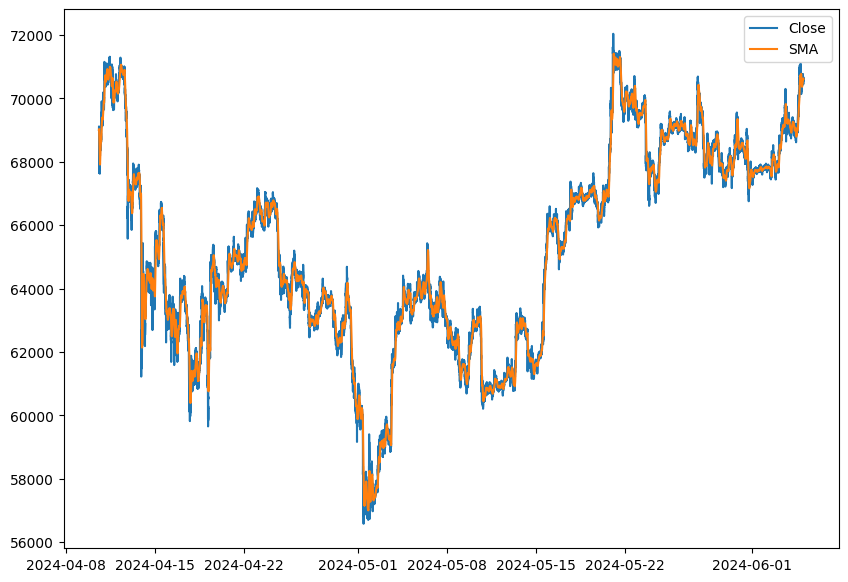

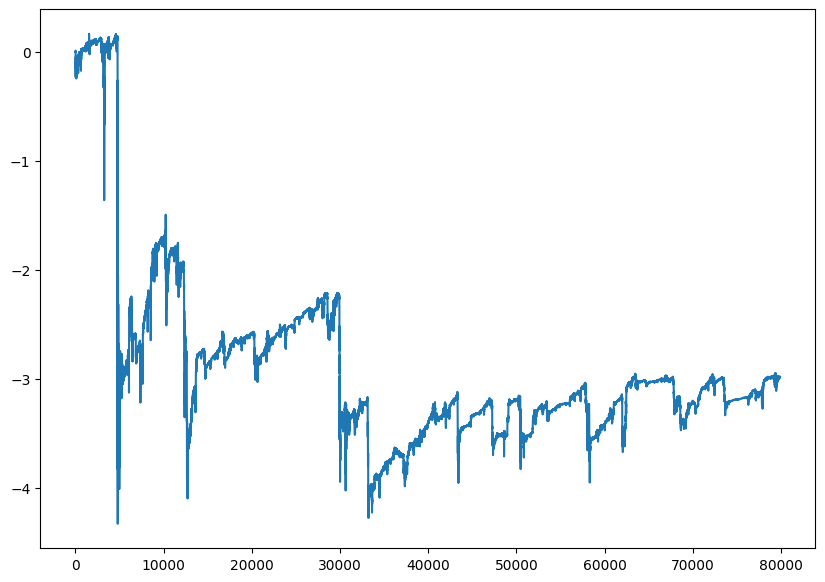

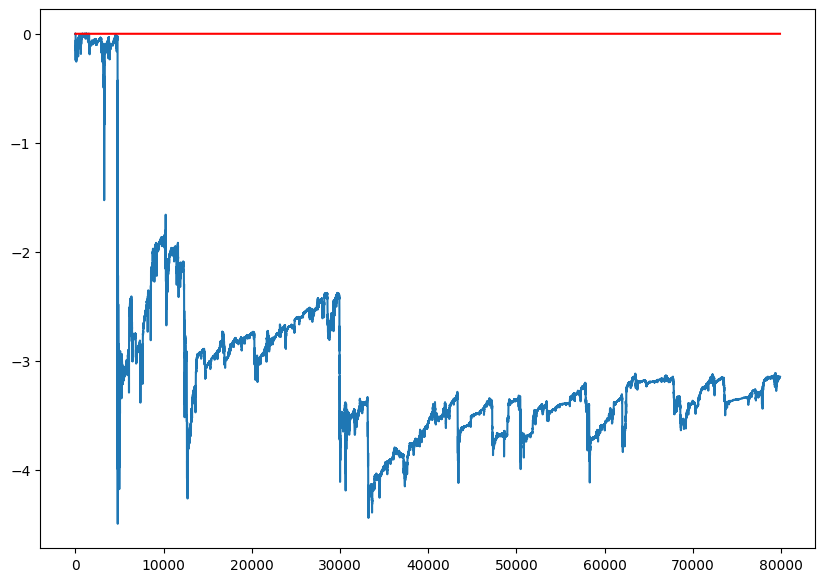

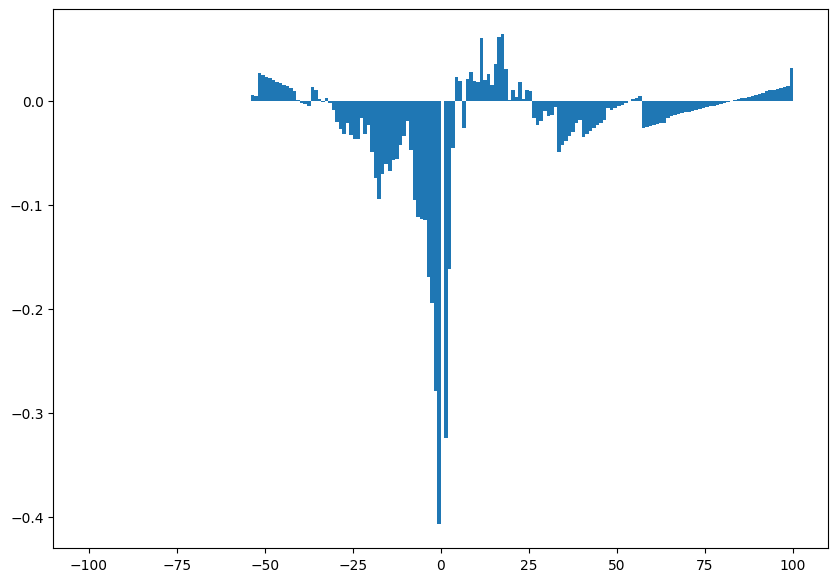

In [34]:
bt = Backtest(data[:int(len(data)*0.8)])
bt.run()
bt.plot()

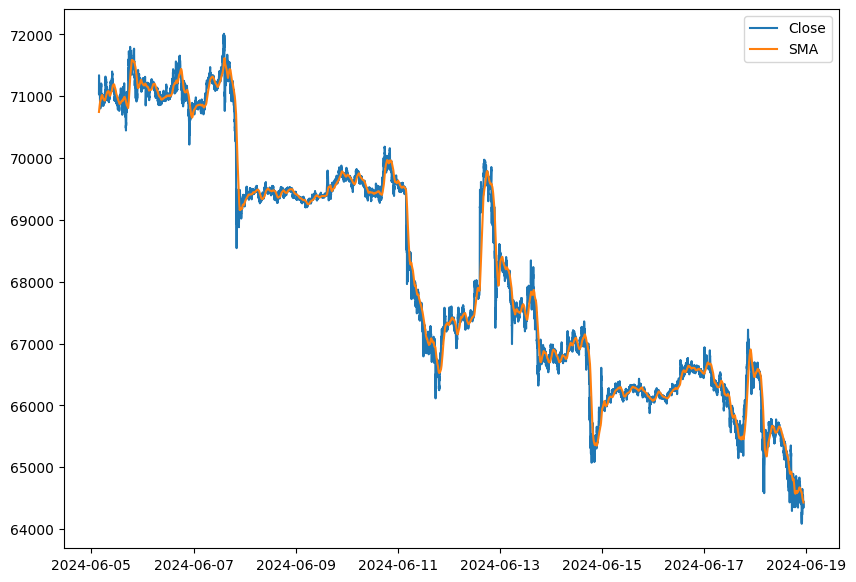

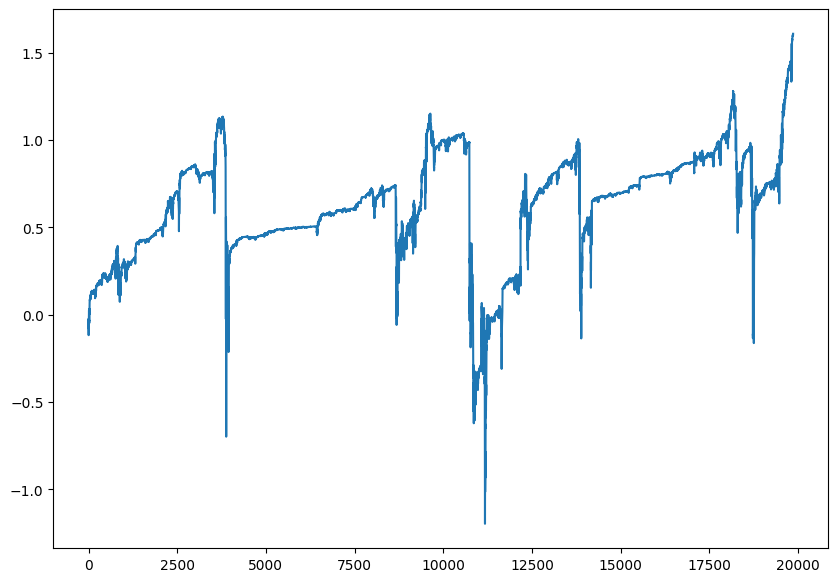

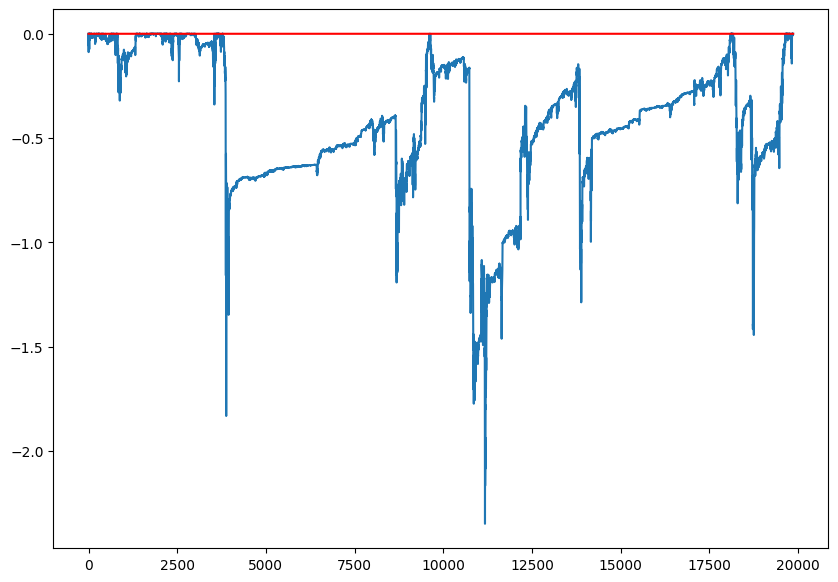

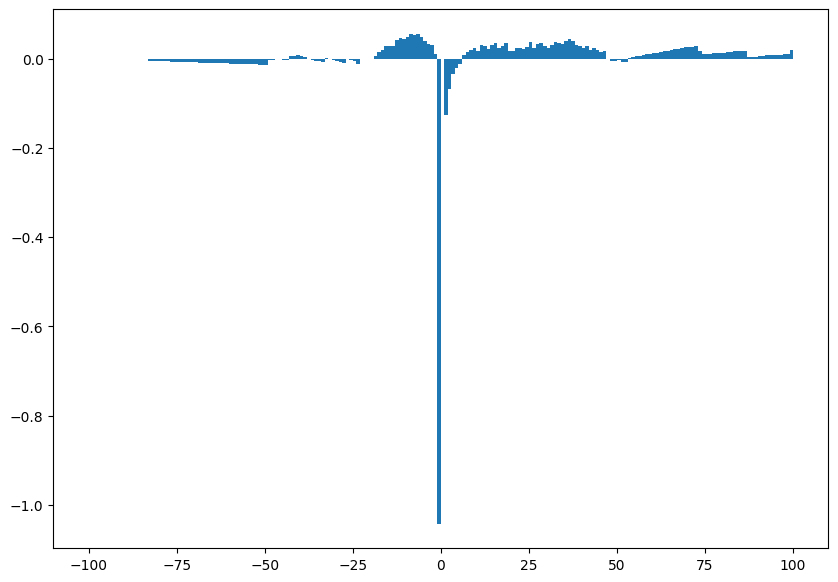

In [35]:
bt = Backtest(data[int(len(data)*0.8):])
bt.run()
bt.plot()

In [80]:
%timeit bt.calc_balance()

9.07 ms ± 390 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
from numba import jit, njit, prange, vectorize, float64, int64, cuda, float32
from numba.typed import List

class Backtest:
    def __init__(self, data, num_grid=100):
        
        self.num_grid = num_grid
    
        self.data = data
        
        self.decimal = len(str(data.iloc[0]['Close']).split('.')[1]) if '.' in str(data.iloc[0]['Close']) else 0
        
        self.data['SMA'] = self.data['Close'].rolling(window=20).mean().round(self.decimal)
        
        self.max_diff = ((self.data['SMA']-self.data['Close'])/self.data['SMA']).abs().max()
        
        print(self.max_diff)
        
        self.data = self.data.dropna()
        
        self.orders = {
            'id': np.concatenate([np.linspace(-self.num_grid, -1, self.num_grid, dtype=int), np.linspace(1, self.num_grid, self.num_grid, dtype=int)]),
            'open_price': np.concatenate([np.linspace(self.max_diff, -self.max_diff, self.num_grid, dtype=float), np.linspace(self.max_diff, -self.max_diff, self.num_grid, dtype=float)]),
            'close_price': np.zeros(self.num_grid*2),
            'amount': np.concatenate([-np.ones(self.num_grid), np.ones(self.num_grid)])/self.num_grid,
            }
        
        self.orders = pd.DataFrame(self.orders)
        
        
        
    @staticmethod
    @njit(parallel=True, fastmath=True)
    def run_jit( data, orders):
        
        
        opened_idx = np.full(len(orders), -1)
        opened_price = np.full(len(orders), -1)
        num_positions = np.zeros(len(orders), dtype=np.int64)
        
        portfolio = np.zeros((len(data), len(orders)), dtype=np.float64)
        
        usdt_returns = np.zeros((len(data), len(orders)), dtype=np.float64)

        for j in range(len(orders)):
                
            id, open_on, close_on, amount = orders[j]
            
            for i in range(len(data)):
            
                open, high, low, close, volume, sma = data[i]
            

                
                open_price = (open_on +1 ) * sma
                close_price = (close_on +1 ) * sma
                
                if opened_price[j] < 0: # not opened
                    if amount > 0: # long
                        if low < open_price:
                            opened_price[j] = open_price
                            opened_idx[j] = i
                            
                            usdt_returns[i, j] = -1
                            
                    elif amount < 0: # short
                        if high > open_price:
                            opened_price[j] = open_price
                            opened_idx[j] = i
                            
                            usdt_returns[i, j] = -1
                            
                else: # opened
                    if amount > 0: # long
                        if high > close_price:
                            
                            usdt_returns[i, j] = 1/opened_price[j]*close_price

                            opened_price[j] = -1
                            opened_idx[j] = -1

                    elif amount < 0: # short
                        if low < close_price:
                            
                            usdt_returns[i, j] = -1/opened_price[j]*close_price

                            opened_price[j] = -1
                            opened_idx[j] = -1
                
                if opened_price[j] > 0:
                    num_positions[j] += 1
                
                
        return usdt_returns, pos

    def run(self):
        
        # positions = self.run_jit(self.data.to_numpy(), self.orders.to_numpy())

        # self.positions = positions
        
        self.usdt_returns, self.btc_returns= self.run_jit(self.data.to_numpy(), self.orders.to_numpy())
        
        # np.mean(pos, axis=0)
        
        return pos
            
    @staticmethod
    @njit(float64[:,:](float64[:,:], float64[:]), parallel=True, fastmath=True)
    def dot(A,B):
        

        
        for i in prange(A.shape[0]):
            A[i] = A[i] * B



        return A

    def calc_balance(self):
        
        # self.usdt_returns1 = self.multiply_jit(self.usdt_returns, self.orders['amount'].to_numpy())

        self.usdt_returns1 = np.multiply(self.usdt_returns, self.orders['amount'].to_numpy())
        
        # print(self.usdt_returns.shape, self.orders['amount'].shape)
        
        # self.usdt_returns1 = self.usdt_returns * self.orders['amount'].values
        
        # self.usdt_returns = self.positions[:, :, 0] * self.positions[:, :, 1]
        
        # self.btc_returns = self.positions[:, :, 1] 
        
    def jit_test(self):
        
        r = self.dot(self.usdt_returns, self.orders['amount'].to_numpy()*1000)
        
        


bt = Backtest(data)

pos= bt.run()

bt.calc_balance()

bt.jit_test()